In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def check_green_box(image_path):
    """
    Check if there's a green box in the bottom-left corner of the image.
    """
    image = cv2.imread(image_path)
    if image is None:
        return False  # If image is not loaded properly

    # Get image dimensions
    height, width, _ = image.shape

    # Define bottom-left region (adjust size based on green box size)
    region = image[int(0.8 * height):, :int(0.3 * width)]

    # Convert to HSV color space for better color detection
    hsv = cv2.cvtColor(region, cv2.COLOR_BGR2HSV)

    # Define green color range (adjust values if needed)
    lower_green = np.array([35, 50, 50])   # Lower bound for green
    upper_green = np.array([85, 255, 255]) # Upper bound for green

    # Create mask for green color detection
    mask = cv2.inRange(hsv, lower_green, upper_green)
    green_pixels = cv2.countNonZero(mask)

    # If green pixels exceed a threshold, consider it a green box
    if green_pixels > 500:  # Adjust this threshold based on box size
        return True
    return False

def classify_images(source_folder, target_folder_with_box, target_folder_without_box):
    """
    Analyze all images in the source folder and classify them based on the green box.
    """
    if not os.path.exists(target_folder_with_box):
        os.makedirs(target_folder_with_box)

    if not os.path.exists(target_folder_without_box):
        os.makedirs(target_folder_without_box)

    for filename in tqdm(os.listdir(source_folder)):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(source_folder, filename)
            if check_green_box(image_path):
                cv2.imwrite(os.path.join(target_folder_with_box, filename), cv2.imread(image_path))
            else:
                cv2.imwrite(os.path.join(target_folder_without_box, filename), cv2.imread(image_path))

# Paths
source_folder = "/content/drive/MyDrive/ESCC/no-esophagus"  # Folder containing all 8500 images
target_folder_with_box = "/content/drive/MyDrive/ESCC/no-esophagus/withbox"  # Folder for images with green box
target_folder_without_box = "/content/drive/MyDrive/ESCC/no-esophagus/extracted_images"  # Folder for images without green box

# Run classification
classify_images(source_folder, target_folder_with_box, target_folder_without_box)

100%|██████████| 8975/8975 [10:45<00:00, 13.90it/s]


In [ ]:
import albumentations as A
import cv2
import os
import numpy as np
from tqdm import tqdm

# Paths
source_path = "/content/drive/MyDrive/ESCC/esophagus"
augmented_path = "/content/drive/MyDrive/ESCC/esophagus/augmented_esophagus"
os.makedirs(augmented_path, exist_ok=True)

# Count images
original_images = os.listdir(source_path)
original_count = len(original_images)
target_count = 4232
images_needed = target_count - original_count

# Augmentation Pipeline
augment = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
])

print(f"Original Images: {original_count}, Augmenting to: {target_count}")

# Augmentation Loop
augmented_count = 0
while augmented_count < images_needed:
    for img_name in tqdm(original_images, desc="Augmenting Images"):
        if augmented_count >= images_needed:
            break
        img_path = os.path.join(source_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        # Apply augmentation
        augmented_img = augment(image=img)['image']
        save_path = os.path.join(augmented_path, f"aug_{augmented_count}.jpg")
        cv2.imwrite(save_path, augmented_img)
        augmented_count += 1

print(f"Augmentation completed! Generated {images_needed} augmented images.")

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-8-13094c8f473b>:26: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),


Original Images: 1690, Augmenting to: 4232


Augmenting Images:  50%|█████     | 853/1690 [01:32<01:30,  9.20it/s]

Augmentation completed! Generated 2542 augmented images.


In [ ]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define source and destination paths
source_folder = '/content/drive/MyDrive/ESCC/esophagus/augmented_esophagus'  # Replace with your source folder path
destination_folder = '/content/drive/MyDrive/ESCC/esophagus'  # Replace with your destination folder path

# Check if the destination folder exists, if not, create it
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Copy all files from source to destination
for filename in os.listdir(source_folder):
    source_file = os.path.join(source_folder, filename)
    destination_file = os.path.join(destination_folder, filename)

    if os.path.isfile(source_file):  # Check if it's a file
        shutil.copy(source_file, destination_file)

print("Files copied successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files copied successfully!


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os

# Paths
dataset_path = '/content/drive/MyDrive/ESCC1'
img_size = 224
batch_size = 32

# Data augmentation and loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Load pre-trained VGG16 model + exclude top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Found 6771 images belonging to 2 classes.
Found 1692 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 4083s 19s/step - accuracy: 0.8526 - loss: 0.3298 - val_accuracy: 0.9415 - val_loss: 0.1539
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 205s 967ms/step - accuracy: 0.9520 - loss: 0.1344 - val_accuracy: 0.9480 - val_loss: 0.1298
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 255s 936ms/step - accuracy: 0.9614 - loss: 0.1033 - val_accuracy: 0.9533 - val_loss: 0.1198
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 194s 917ms/step - accuracy: 0.9650 - loss: 0.0881 - val_accuracy: 0.9574 - val_loss: 0.1133
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 193s 913ms/step - accuracy: 0.9728 - loss: 0.0768 - val_accuracy: 0.9220 - val_loss: 0.1883
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 195s 920ms/step - accuracy: 0.9708 - loss: 0.0771 - val_accuracy: 0.9704 - val_loss: 0.0826
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 194s 914ms/step - accuracy: 0.9736 - loss: 0.0705 - val_accuracy: 0.9740 - val_loss: 0.0718
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 194s 917ms/step - accuracy: 0.9723 - 

In [ ]:
print(train_generator.class_indices)
# Likely: {'diseased': 0, 'non-diseased': 1} or vice versa

{'diseased': 0, 'nondiseased': 1}


In [ ]:
model.save("/content/drive/MyDrive/ESCC1/models/VGG16_base.h5")

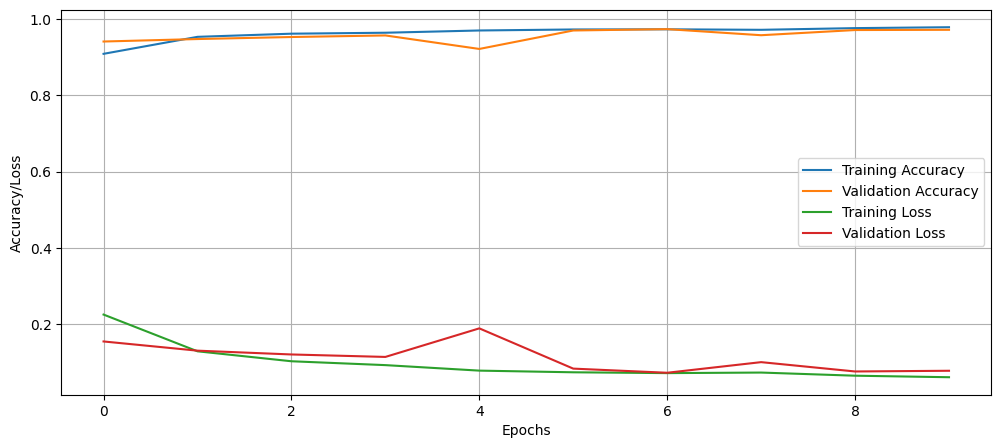

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.grid()
plt.show()

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os

# Paths
dataset_path = '/content/drive/MyDrive/ESCC1'
img_size = 224
batch_size = 32

# Data augmentation and loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 6771 images belonging to 2 classes.
Found 1692 images belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

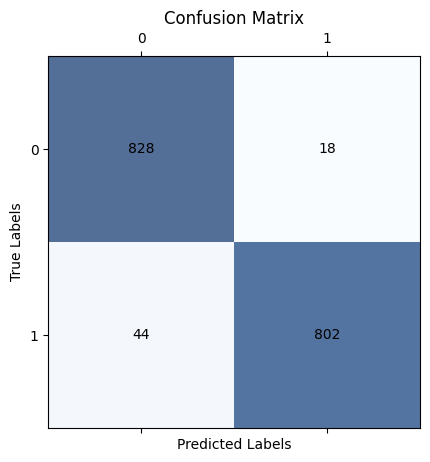

In [2]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/models/VGG16_base.h5")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Get the total number of samples in the validation set
total_samples = len(val_generator.filenames)

# Initialize lists to collect all true labels and predicted probabilities
all_true_labels = []
all_pred_probs = []

# Loop through all batches in the validation generator
for i in range(len(val_generator)):
    x_batch, y_true_batch = val_generator[i]  # Get the i-th batch
    all_true_labels.extend(y_true_batch)
    y_pred_prob_batch = model.predict(x_batch)
    all_pred_probs.extend(y_pred_prob_batch)

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_pred_probs = np.array(all_pred_probs)

# Set the optimal threshold and get predicted labels
optimal_threshold = 0.5
all_pred_labels = (all_pred_probs >= optimal_threshold).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(all_true_labels, all_pred_labels))

# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.matshow(cm, cmap='Blues', alpha=0.7)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")
plt.show()


### CLAHE

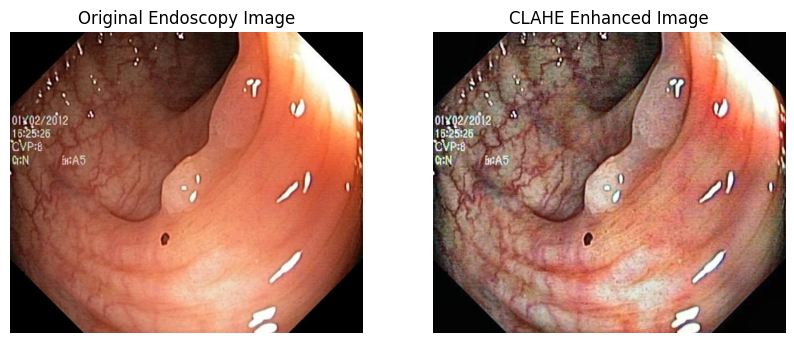

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the endoscopy image in color (BGR format)
image = cv2.imread('/content/drive/MyDrive/ESCC1/diseased/0004a718-546c-41c2-9c69-c4685093a039.jpg')

# Check if image loaded successfully
if image is None:
    print("Error: Image not found.")
    exit()

# Split the image into its BGR channels
b, g, r = cv2.split(image)

# Create CLAHE object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Apply CLAHE to each channel
b = clahe.apply(b)
g = clahe.apply(g)
r = clahe.apply(r)

# Merge the channels back
clahe_image = cv2.merge((b, g, r))

# Display the original and CLAHE-enhanced images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("Original Endoscopy Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("CLAHE Enhanced Image")
plt.axis('off')

plt.show()


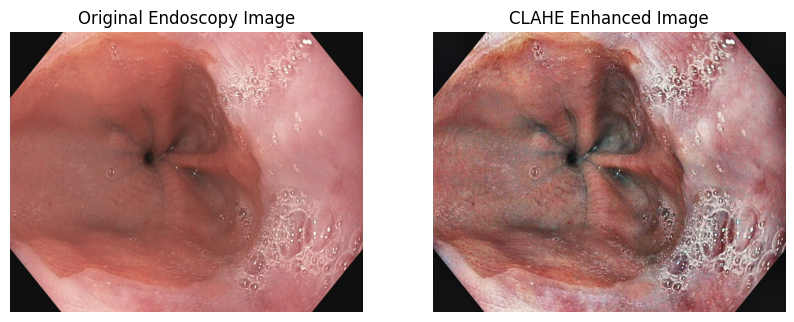

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the endoscopy image in color (BGR format)
image = cv2.imread('/content/drive/MyDrive/ESCC1/nondiseased/001dcfa9-0cac-4b07-9cec-bc70944cd4d3.jpg')

# Check if image loaded successfully
if image is None:
    print("Error: Image not found.")
    exit()

# Split the image into its BGR channels
b, g, r = cv2.split(image)

# Create CLAHE object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Apply CLAHE to each channel
b = clahe.apply(b)
g = clahe.apply(g)
r = clahe.apply(r)

# Merge the channels back
clahe_image = cv2.merge((b, g, r))

# Display the original and CLAHE-enhanced images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("Original Endoscopy Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("CLAHE Enhanced Image")
plt.axis('off')

plt.show()


### CLAHE WITH MASKING

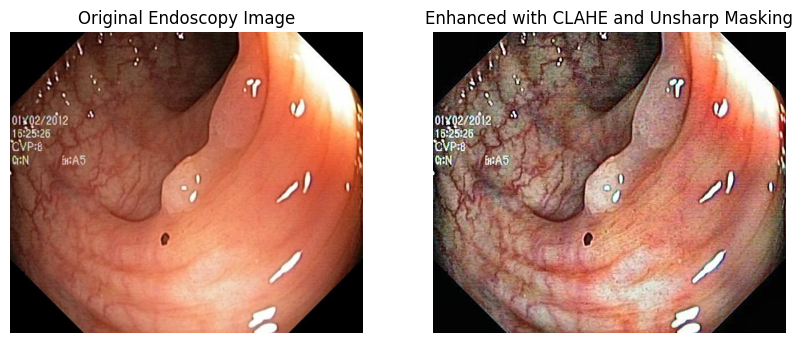

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the endoscopy image in color (BGR format)
image = cv2.imread('/content/drive/MyDrive/ESCC1/diseased/0004a718-546c-41c2-9c69-c4685093a039.jpg')

# Check if image loaded successfully
if image is None:
    print("Error: Image not found.")
    exit()

# Split the image into its BGR channels
b, g, r = cv2.split(image)

# Apply CLAHE to each channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
b_clahe = clahe.apply(b)
g_clahe = clahe.apply(g)
r_clahe = clahe.apply(r)

# Merge the enhanced BGR channels back
clahe_image = cv2.merge((b_clahe, g_clahe, r_clahe))

# Create Unsharp Masking
# Apply Gaussian blur to each channel
b_blurred = cv2.GaussianBlur(b_clahe, (5, 5), 1.5)
g_blurred = cv2.GaussianBlur(g_clahe, (5, 5), 1.5)
r_blurred = cv2.GaussianBlur(r_clahe, (5, 5), 1.5)

# Subtract the blurred images from the original CLAHE-enhanced images
b_sharpened = cv2.addWeighted(b_clahe, 1.5, b_blurred, -0.5, 0)
g_sharpened = cv2.addWeighted(g_clahe, 1.5, g_blurred, -0.5, 0)
r_sharpened = cv2.addWeighted(r_clahe, 1.5, r_blurred, -0.5, 0)

# Merge the sharpened channels back
final_image = cv2.merge((b_sharpened, g_sharpened, r_sharpened))

# Display the original and the enhanced image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("Original Endoscopy Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("Enhanced with CLAHE and Unsharp Masking")
plt.axis('off')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

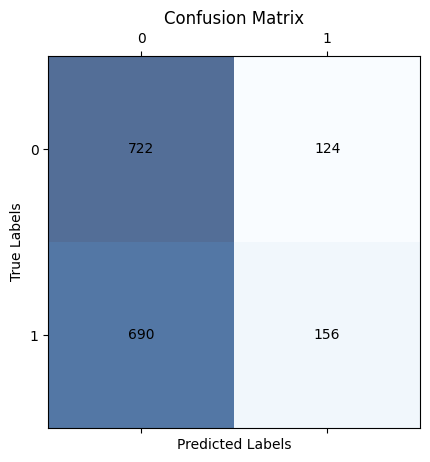

In [3]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/models/InceptionV3_base_augumented.h5")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Get the total number of samples in the validation set
total_samples = len(val_generator.filenames)

# Initialize lists to collect all true labels and predicted probabilities
all_true_labels = []
all_pred_probs = []

# Loop through all batches in the validation generator
for i in range(len(val_generator)):
    x_batch, y_true_batch = val_generator[i]  # Get the i-th batch
    all_true_labels.extend(y_true_batch)
    y_pred_prob_batch = model.predict(x_batch)
    all_pred_probs.extend(y_pred_prob_batch)

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_pred_probs = np.array(all_pred_probs)

# Set the optimal threshold and get predicted labels
optimal_threshold = 0.5
all_pred_labels = (all_pred_probs >= optimal_threshold).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(all_true_labels, all_pred_labels))

# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.matshow(cm, cmap='Blues', alpha=0.7)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")
plt.show()
